In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Subset

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),      
])

## CNN

In [4]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        # Global average pooling instead of large fully connected layers
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
        # Smaller fully connected layers
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 128x128 -> 64x64
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 64x64 -> 32x32
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 32x32 -> 16x16
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # 16x16 -> 8x8
        
        # Global average pooling (reduces to 256x1x1)
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        
        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

In [5]:
model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (global_pool): AdaptiveAvgPool2d(output_size=1)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


In [6]:
def train_loop(dataloader, model, loss_fn, optimizer, batch_size=64):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    y_preds = []
    y_tests = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            # Save predictions and true labels
            y_preds.extend(pred.argmax(dim=1).cpu().numpy())
            y_tests.extend(y.cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct, y_tests, y_preds

In [7]:
def train_model(train_dataloader, test_dataloader, epochs, optimizer, loss_fn, patience):
    # Early stopping variables
    best_loss = float('inf')
    trigger_times = 0
    best_model_weights = model.state_dict()
    best_epoch = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss, acc, y_tests, y_preds = test_loop(test_dataloader, model, loss_fn)

        if test_loss < best_loss:
            best_loss = test_loss
            best_acc = acc
            trigger_times = 0
            best_model_weights = model.state_dict()
            best_epoch = t+1
            # torch.save(best_model_weights, 'best_model.pth')
            # print(f"New best model saved at epoch {t+1}.")
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"Early stopping at epoch {t+1}. No improvement in {patience} epochs.")
                break

    # model.load_state_dict(torch.load('best_model.pth')) # load best model weights
    print(f"Best epoch at {best_epoch} with accuracy {(100*best_acc):>0.1f} and loss {best_loss}")
    
    return y_tests, y_preds

## PlantVillage

### Load Dataset

In [8]:
dataset_dir = "PlantVillage"
dataset = datasets.ImageFolder(root=dataset_dir, transform=transform)

In [9]:
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42, stratify=dataset.targets)

train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

In [10]:
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=64, shuffle=False)

### Model Training

In [11]:
learning_rate = 0.001
# momentum = 0.9
epochs = 60
patience = 10

In [12]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
y_tests, y_preds = train_model(train_dataloader, test_dataloader, epochs, optimizer, loss_fn, patience)

Epoch 1
-------------------------------
loss: 1.774267  [   64/ 5600]
Test Error: 
 Accuracy: 64.0%, Avg loss: 1.112268 

Epoch 2
-------------------------------
loss: 0.250541  [   64/ 5600]
Test Error: 
 Accuracy: 67.9%, Avg loss: 1.030245 

Epoch 3
-------------------------------
loss: 0.342593  [   64/ 5600]
Test Error: 
 Accuracy: 80.9%, Avg loss: 0.462343 

Epoch 4
-------------------------------
loss: 0.235477  [   64/ 5600]
Test Error: 
 Accuracy: 67.9%, Avg loss: 1.316588 

Epoch 5
-------------------------------
loss: 0.198838  [   64/ 5600]
Test Error: 
 Accuracy: 84.9%, Avg loss: 0.447525 

Epoch 6
-------------------------------
loss: 0.057068  [   64/ 5600]
Test Error: 
 Accuracy: 78.9%, Avg loss: 0.613854 

Epoch 7
-------------------------------
loss: 0.094651  [   64/ 5600]
Test Error: 
 Accuracy: 67.6%, Avg loss: 1.485278 

Epoch 8
-------------------------------
loss: 0.183655  [   64/ 5600]
Test Error: 
 Accuracy: 79.5%, Avg loss: 1.251651 

Epoch 9
----------------

### Model Evaluation

In [14]:
classes = ["healthy", "early_blight", "late_blight", "bacterial_spot", "mosaic_virus"]
print(classification_report(y_tests, y_preds, target_names=classes))

                precision    recall  f1-score   support

       healthy       1.00      0.92      0.96       425
  early_blight       0.84      0.64      0.73       200
   late_blight       0.97      0.99      0.98       318
bacterial_spot       0.86      0.99      0.92       382
  mosaic_virus       0.84      1.00      0.91        75

      accuracy                           0.92      1400
     macro avg       0.90      0.91      0.90      1400
  weighted avg       0.92      0.92      0.92      1400



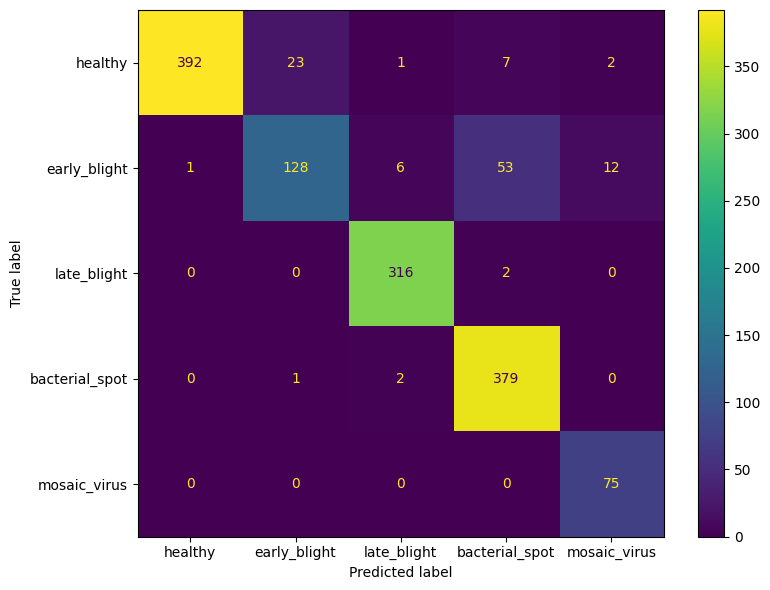

In [15]:
cm = confusion_matrix(y_tests, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.tight_layout()

## PlantDoc

### Load Dataset

In [16]:
train_subset = datasets.ImageFolder(root="PlantDoc/train", transform=transform)
test_subset = datasets.ImageFolder(root="PlantDoc/test", transform=transform)

In [17]:
train_dataloader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=64, shuffle=False)

### Model Training

In [23]:
learning_rate = 0.001
# momentum = 0.9
epochs = 100
patience = 50

In [24]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
y_tests, y_preds = train_model(train_dataloader, test_dataloader, epochs, optimizer, loss_fn, patience)

Epoch 1
-------------------------------
loss: 0.666403  [   64/  380]
Test Error: 
 Accuracy: 32.6%, Avg loss: 2.521917 

Epoch 2
-------------------------------
loss: 0.683348  [   64/  380]
Test Error: 
 Accuracy: 41.3%, Avg loss: 2.109935 

Epoch 3
-------------------------------
loss: 0.568486  [   64/  380]
Test Error: 
 Accuracy: 39.1%, Avg loss: 2.498443 

Epoch 4
-------------------------------
loss: 0.556948  [   64/  380]
Test Error: 
 Accuracy: 41.3%, Avg loss: 2.202200 

Epoch 5
-------------------------------
loss: 0.545656  [   64/  380]
Test Error: 
 Accuracy: 41.3%, Avg loss: 1.988435 

Epoch 6
-------------------------------
loss: 0.467092  [   64/  380]
Test Error: 
 Accuracy: 39.1%, Avg loss: 2.039449 

Epoch 7
-------------------------------
loss: 0.393519  [   64/  380]
Test Error: 
 Accuracy: 37.0%, Avg loss: 2.507412 

Epoch 8
-------------------------------
loss: 0.530510  [   64/  380]
Test Error: 
 Accuracy: 41.3%, Avg loss: 2.291571 

Epoch 9
----------------

### Model Evaluation

In [26]:
classes = ["healthy", "early_blight", "late_blight", "bacterial_spot", "mosaic_virus"]
print(classification_report(y_tests, y_preds, target_names=classes))

                precision    recall  f1-score   support

       healthy       0.71      0.56      0.62         9
  early_blight       0.40      0.44      0.42         9
   late_blight       0.50      0.25      0.33         8
bacterial_spot       0.47      0.70      0.56        10
  mosaic_virus       0.20      0.20      0.20        10

      accuracy                           0.43        46
     macro avg       0.46      0.43      0.43        46
  weighted avg       0.45      0.43      0.43        46



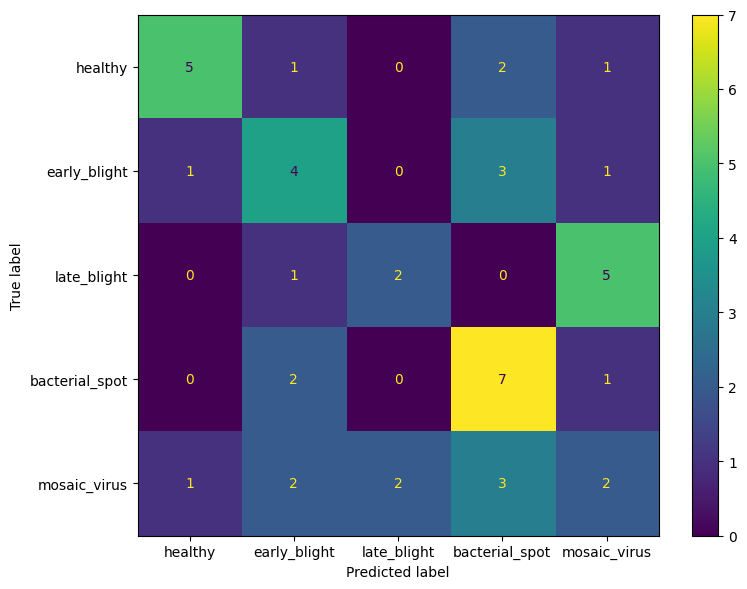

In [27]:
cm = confusion_matrix(y_tests, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.tight_layout()